# Finite elements for BVP with Dirichlet or Neumann homogeneous boundary conditions

## Abstract

This notebook is focused on retrieving an approximate solution for the inhomogeneous BVP that is the time-independent, spatial part of heat equation or of the equation of vibrations:
$$
-\frac{d^2}{dx^2}u(x) = f(x)
$$
with Dirichlet or Neumann homogeneous boundary conditions. \
As one can see, we have assumed for simplicity that the heat conductivity or stiffness of the system is constant and equal to one ($k(x) = 1$). <br><br>

The method used to retrieve a solution is a _finite element method_. This method employs the Galerkin method to restrict the solution from an infinite-dimensional vector space to a finite-dimensional subspace, subject to the same boundary conditions of the original problem. <br> The basis that we choose to span the finite-dimensional subspace is a basis of **linear, piecewise polynomials**. We will call this basis **pp basis** or simply **pp** from now on.

The novelties of the method that is presented here are:
- the implementation of a matrix, interval-wise representation of the piecewise polynomials basis;
- the exploitation of the `sympy` library to perform analytical and numerical calculations and to provide perfect $\LaTeX$ rendering of symbols and expressions;
- a didactic-oriented implementation of the code.

In the end, plots are provided for the true solution, if known, for the approximated solution and for the difference between them.

The default domain of the solution $u(x)$ is the real interval $x\in [0,1]$, but the code can be easily modified to provide a solution on any other closed real interval, by only changing the domain in which the $x$ variable is defined.

_**Note**: even though the code is conceived to be used in a didactic environment, knowledge of the derivation of finite element methods is required to understand the code, together with basic knowledge of the theory behind PDEs such as the heat equation and the equation of vibrations._

In [194]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sympy import *
init_printing()

    # ----------------------------------------------------------------------
        # Parameters to fix

# Solution's domain
domain = Interval(0,1)

# Number of intervals in which to divide the domain
n = 10

# Width of each interval
hvalue = (domain.measure/n).evalf()

# Number of points for the plots
npoints = 1000
npoints_per_interval = int(npoints/n)-1
x_subvalue = hvalue/npoints_per_interval

    # ----------------------------------------------------------------------
        # Main variables definition

u = symbols('u', cls=Function)
x = Symbol('x', real=True, domain=domain)
h = Symbol('h', real=True, positive=True)
i = Symbol('i', integer=True)

## Deep-dive in the matrix representation of the pp basis

Let's explore the abovementioned points in more detail. <br>
The matrix representation of the pp basis starts from representing each element of the basis as a vector of functions: every entry is the value that the single pp element assumes on a specific interval. Each pp element is thus an (n x 1) matrix.

Since we want this method to be able to treat Neumann boundary conditions as well as Dirichlet, we will start with the largest pp basis that we can have, that is required by Neumann conditions. Having an n-dimensional subspace $V_n = C^2_N (0,1)$, we need **n+1 pp basis' elements**, since we have no vanishing conditions at the borders of the interval (as with Dirichlet BC). <br> So our basis will be given by the $\phi_i$ functions:

In [195]:
phi_list = [symbols(f'phi_{i}', cls=Function) for i in range(n+1)]; pprint(phi_list)       

[φ₀, φ₁, φ₂, φ₃, φ₄, φ₅, φ₆, φ₇, φ₈, φ₉, φ₁₀]


The domain of the ODE is defined by the `sympy.Interval` object defined below, and divided in `n` intervals of width `hvalue`. We can call each interval $X_i$, being $X_0 = [0, h]$ and $X_{n-1} = [1-h, h]$. <br> We should build a vector of our intervals, $X_i$: 

In [196]:
x_list = [Symbol(f'X_{i}') for i in range(n)]; pprint(x_list)

[X₀, X₁, X₂, X₃, X₄, X₅, X₆, X₇, X₈, X₉]


Now let's focus on the values that the pp elements take on each interval. We know that each $\phi_i$ element is an ascending line on the interval $X_i$ and a descending line on the interval $X_{i+1}$ and is zero elsewhere. <br><br> By defining `enn` the analytical expression of the ascending line,

In [197]:
enn = x/h - i + S.One; print("enn =", enn)

enn = -i + 1 + x/h


and `e00` the analytical expression of the descending line,

In [198]:
e00 = -x/h + i + S.One; print("e00 =", e00)

e00 = i + 1 - x/h


we can write the element $\phi_i$ of the basis (with $i = 1, 2, ..., n-1$) as:

In [199]:
sy_basis = Piecewise(
    (enn, (x>(i-1)*h)&(x<i*h)),
    (e00, (x>i*h)&(x<(i+1)*h)),
    (0, True),
); sy_basis

⎧         x                             
⎪-i + 1 + ─  for x > h⋅(i - 1) ∧ x < h⋅i
⎪         h                             
⎪                                       
⎨        x                              
⎪i + 1 - ─   for x > h⋅i ∧ x < h⋅(i + 1)
⎪        h                              
⎪                                       
⎩    0                otherwise         

As an example, the $\phi_0$ element will be represented, as a vector, meaning that we have "projected" it on the basis of the intervals $X_i$, as:

In [200]:
[ e00 if i==0 else 0 for i in range(len(x_list)) ]

and the last element of the pp basis, $\phi_n$ will be: 

In [201]:
[ enn if i==n-1 else 0 for i in range(len(x_list)) ]

We can build all the pp elements in this way and then group them in a matrix, whose rows are the pp elements, and whose columns are the intervals.

In [202]:
symbollist = []
for a in range(len(phi_list)):
    lista = [S.Zero for b in range(len(x_list))]
    for b in range(len(x_list)):
        if (a!=0)&(b==a-1):  lista[b]=phi_list[a](x_list[b])
        elif a==b:  lista[b]=phi_list[a](x_list[a])
    symbollist.append(lista)
symbolic = Matrix(symbollist); symbolic

⎡φ₀(X₀)    0       0       0       0       0       0       0       0        0 
⎢                                                                             
⎢φ₁(X₀)  φ₁(X₁)    0       0       0       0       0       0       0        0 
⎢                                                                             
⎢  0     φ₂(X₁)  φ₂(X₂)    0       0       0       0       0       0        0 
⎢                                                                             
⎢  0       0     φ₃(X₂)  φ₃(X₃)    0       0       0       0       0        0 
⎢                                                                             
⎢  0       0       0     φ₄(X₃)  φ₄(X₄)    0       0       0       0        0 
⎢                                                                             
⎢  0       0       0       0     φ₅(X₄)  φ₅(X₅)    0       0       0        0 
⎢                                                                             
⎢  0       0       0       0       0     φ₆(X₅)  φ₆(

Starting from the above matrix, we can prove that the construction of the stiffness matrix and of the vector representation of the RHS (right hand side) of the ODE can be implemented in a very clear and efficient way.

## Building the stiffness matrix

The stiffness matrix contains as entries the energy-inner products of the elements of the pp basis:
$$
K_{ij} = \int_0^1 dx \ k \frac{d \phi_i (x)}{dx}\frac{d \phi_j (x)}{dx}
$$
This inner product is not null only for $j = i$ or $j = i \pm 1$. <br><br>
With our matrix representation, the K matrix can be computed very easily with these steps:
- compute the matrix of the derivatives of the entries of the matrix -> `de`
- compute the matrix of the integrands of the $K_{ij}$ entries by the matrix product between `de` and its transpose -> `Iij`
- integrate each entry -> `Kij`

Regarding the latter point, since the integrands are constants, we can integrate between 0 and h, as we were considering a single interval (that is the assumption on which we have built the initial matrix). The reader should notice that **we are not imposing in any way the symmetry of the matrix K: that is a result of the procedure itself**.

In [203]:
symbolic_de = symbolic.applyfunc(lambda entry : entry.diff(x, evaluate=False) if entry!=0 else 0); symbolic_de

⎡d                                                                            
⎢──(φ₀(X₀))      0           0           0           0           0           0
⎢dx                                                                           
⎢                                                                             
⎢d           d                                                                
⎢──(φ₁(X₀))  ──(φ₁(X₁))      0           0           0           0           0
⎢dx          dx                                                               
⎢                                                                             
⎢            d           d                                                    
⎢    0       ──(φ₂(X₁))  ──(φ₂(X₂))      0           0           0           0
⎢            dx          dx                                                   
⎢                                                                             
⎢                        d           d              

In [204]:
symbolic_Iij = symbolic_de*symbolic_de.T; symbolic_Iij

⎡                2                                                            
⎢    ⎛d         ⎞           d          d                                      
⎢    ⎜──(φ₀(X₀))⎟           ──(φ₀(X₀))⋅──(φ₁(X₀))                    0        
⎢    ⎝dx        ⎠           dx         dx                                     
⎢                                                                             
⎢                                   2               2                         
⎢d          d           ⎛d         ⎞    ⎛d         ⎞       d          d       
⎢──(φ₀(X₀))⋅──(φ₁(X₀))  ⎜──(φ₁(X₀))⎟  + ⎜──(φ₁(X₁))⎟       ──(φ₁(X₁))⋅──(φ₂(X₁
⎢dx         dx          ⎝dx        ⎠    ⎝dx        ⎠       dx         dx      
⎢                                                                             
⎢                                                                  2          
⎢                           d          d               ⎛d         ⎞    ⎛d     
⎢          0                ──(φ₁(X₁))⋅──(φ₂(X₁))   

In [225]:
symbolic_Kij = symbolic_Iij.applyfunc(
    lambda entry :
    Integral(UnevaluatedExpr(entry), (x, S.Zero, h)) if entry != 0
    else 0
); symbolic_Kij

⎡    h                                                                        
⎢    ⌠                           h                                            
⎢    ⎮             2             ⌠                                            
⎢    ⎮ ⎛d         ⎞              ⎮ d          d                               
⎢    ⎮ ⎜──(φ₀(X₀))⎟  dx          ⎮ ──(φ₀(X₀))⋅──(φ₁(X₀)) dx                   
⎢    ⎮ ⎝dx        ⎠              ⎮ dx         dx                              
⎢    ⌡                           ⌡                                            
⎢    0                           0                                            
⎢                                                                             
⎢                            h                                                
⎢h                           ⌠                                       h        
⎢⌠                           ⎮             2               2         ⌠        
⎢⎮ d          d              ⎮ ⎛d         ⎞    ⎛d   

## Building the vector representation of the RHS of ODE

In [206]:
rhs = symbols('f', cls=Function)

In [207]:
symbolic_If = symbolic.applyfunc(lambda entry : entry*rhs(x)); symbolic_If

⎡f(x)⋅φ₀(X₀)       0            0            0            0            0      
⎢                                                                             
⎢f(x)⋅φ₁(X₀)  f(x)⋅φ₁(X₁)       0            0            0            0      
⎢                                                                             
⎢     0       f(x)⋅φ₂(X₁)  f(x)⋅φ₂(X₂)       0            0            0      
⎢                                                                             
⎢     0            0       f(x)⋅φ₃(X₂)  f(x)⋅φ₃(X₃)       0            0      
⎢                                                                             
⎢     0            0            0       f(x)⋅φ₄(X₃)  f(x)⋅φ₄(X₄)       0      
⎢                                                                             
⎢     0            0            0            0       f(x)⋅φ₅(X₄)  f(x)⋅φ₅(X₅) 
⎢                                                                             
⎢     0            0            0            0      

In [208]:
symb_fflist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if symbolic_If.row(a)[b]!=0:
            lista[b]=(UnevaluatedExpr(symbolic_If.row(a)[b]).integrate((x, b*h, (b+1)*h)))
        else: lista[b]=0
    symb_fflist.append(lista)
symbolic_fij = Matrix(symb_fflist); symbolic_fij

⎡h                                                                            
⎢⌠                                                                            
⎢⎮ f(x)⋅φ₀(X₀) dx          0                   0                   0          
⎢⌡                                                                            
⎢0                                                                            
⎢                                                                             
⎢h                 2⋅h                                                        
⎢⌠                  ⌠                                                         
⎢⎮ f(x)⋅φ₁(X₀) dx   ⎮  f(x)⋅φ₁(X₁) dx          0                   0          
⎢⌡                  ⌡                                                         
⎢0                  h                                                         
⎢                                                                             
⎢                  2⋅h                 3⋅h          

In [209]:
ones = Matrix([S.One for i in range(n)])

symb_flist = []
for a in range(n+1):
    symb_flist.append(symbolic_fij.row(a)*ones)
symbolic_fi = Matrix(symb_flist); symbolic_fi

⎡            h                           ⎤
⎢            ⌠                           ⎥
⎢            ⎮ f(x)⋅φ₀(X₀) dx            ⎥
⎢            ⌡                           ⎥
⎢            0                           ⎥
⎢                                        ⎥
⎢ h                  2⋅h                 ⎥
⎢ ⌠                   ⌠                  ⎥
⎢ ⎮ f(x)⋅φ₁(X₀) dx +  ⎮  f(x)⋅φ₁(X₁) dx  ⎥
⎢ ⌡                   ⌡                  ⎥
⎢ 0                   h                  ⎥
⎢                                        ⎥
⎢2⋅h                  3⋅h                ⎥
⎢ ⌠                    ⌠                 ⎥
⎢ ⎮  f(x)⋅φ₂(X₁) dx +  ⎮  f(x)⋅φ₂(X₂) dx ⎥
⎢ ⌡                    ⌡                 ⎥
⎢ h                   2⋅h                ⎥
⎢                                        ⎥
⎢3⋅h                  4⋅h                ⎥
⎢ ⌠                    ⌠                 ⎥
⎢ ⎮  f(x)⋅φ₃(X₂) dx +  ⎮  f(x)⋅φ₃(X₃) dx ⎥
⎢ ⌡                    ⌡                 ⎥
⎢2⋅h                  3⋅h                ⎥
⎢          

## Building the solution

Once we have the matrix K and the vector f, we can find the coefficients $u_i$ by solving the linear algebra problem Ku=f. <br>These coefficients are the projection of the approximate solution $v_n$ on the pp basis, and they enter in the finite series that provides it in the finite dimensional subspace $V_n$: \
$$
v_n = \sum_{j=0}^n u_j \phi_j
$$

In problems with Neumann BC, the stiffness matrix $K_{ij}$ is singular, and this means that we cannot invert the problem to solve it, and that the solution is not unique. This is due to the non-triviality of the null space of the operator $-\frac{d^2}{dx^2}$ in a domain with Neumann boundary conditions. Since the null-space is one-dimensional (we have 1 degree of freedom in choosing any arbitrary constant to add to the solution, and we would still get a solution), this leads to having one row and one column more than we need in the $(n+1)\times (n+1)$ stiffness matrix. One can solve this issue by simply removing the last row and column from the $K_{ij}$ matrix, that correspond to the energy-inner product of the pp element $\phi_n$ on the last interval of the domain, $X_{n-1}$. In this way we are automatically selecting the approximate solution that satisfies Dirichlet boundary conditions at its rightmost end, so we are imposing $v_n(1) = 0$. The same popping of the last element has to be applied to the vector $f$ as well. This procedure leads to a non-singular $K_ij$ matrix, and the linear algebra problem Ku=f is exactly solvable.<br>

The fact that the removal of the last row and column is equivalent to imposing Dirichlet BC at one end of the domain leads us to understand that to solve homogeneous Dirichlet BVP with our code we only need to remove the last row and column, of course, as well as the first row and column. We will see that this is the only thing we need to do to make the general code specific for those boundary conditions.

---

The solution of the linear algebra problem Ku=f can be found by using the `LUsolve` method in `sympy`, or a number of other equally good routines from `numpy`, such as `solve_banded`, that can be applied to our tridiagonal stiffness matrix K.

---
To build back the approximate solution $v_n$, we have to multiply the coefficients to their relative basis element. To do that, we can properly exploit the matrix of the pp basis that we built at the beginning of the procedure. Matrix product of the pp matrix and the solution's coefficients should provide us with a summation in which the $x$ variable takes any value of the domain. Instead, since we built the pp matrix _interval-wise_, we will obtain the solution as a vector in which each entry represents the value (that is, a function of $x$) that the solution takes on a single interval.

In [210]:
symbolic_ui = Matrix([Symbol(f'u_{i}') for i in range(n+1)]); symbolic_ui

⎡u₀ ⎤
⎢   ⎥
⎢u₁ ⎥
⎢   ⎥
⎢u₂ ⎥
⎢   ⎥
⎢u₃ ⎥
⎢   ⎥
⎢u₄ ⎥
⎢   ⎥
⎢u₅ ⎥
⎢   ⎥
⎢u₆ ⎥
⎢   ⎥
⎢u₇ ⎥
⎢   ⎥
⎢u₈ ⎥
⎢   ⎥
⎢u₉ ⎥
⎢   ⎥
⎣u₁₀⎦

In [211]:
symbolic_u = (symbolic_ui.T*symbolic).T; symbolic_u

⎡ u₀⋅φ₀(X₀) + u₁⋅φ₁(X₀) ⎤
⎢                       ⎥
⎢ u₁⋅φ₁(X₁) + u₂⋅φ₂(X₁) ⎥
⎢                       ⎥
⎢ u₂⋅φ₂(X₂) + u₃⋅φ₃(X₂) ⎥
⎢                       ⎥
⎢ u₃⋅φ₃(X₃) + u₄⋅φ₄(X₃) ⎥
⎢                       ⎥
⎢ u₄⋅φ₄(X₄) + u₅⋅φ₅(X₄) ⎥
⎢                       ⎥
⎢ u₅⋅φ₅(X₅) + u₆⋅φ₆(X₅) ⎥
⎢                       ⎥
⎢ u₆⋅φ₆(X₆) + u₇⋅φ₇(X₆) ⎥
⎢                       ⎥
⎢ u₇⋅φ₇(X₇) + u₈⋅φ₈(X₇) ⎥
⎢                       ⎥
⎢ u₈⋅φ₈(X₈) + u₉⋅φ₉(X₈) ⎥
⎢                       ⎥
⎣u₁₀⋅φ₁₀(X₉) + u₉⋅φ₉(X₉)⎦

In the end, each entry of `u` is a function of $x$, and we must be aware that that variable should take values that are in the interval to which it refers, to have not a meaningless solution. An easy loop on an arbitrary number of subpoints in which to divide each interval will provide the arrays that we need to plot the solution.

---

# Example 6.10 - Steady-state heat equation under homogeneous Neumann conditions 

We now apply the theory that we have developed above to solving the following BVP with Neumann conditions. 


Reference: M. S. Gockenbach, _Partial Differential Equations - Analytical and Numerical Methods_, 2nd edition, Siam. Section 6.5 - Finite elements and Neumann conditions.

## Existence and uniqueness of a solution

The steady-state heat equation BVP with homogeneous Neumann conditions is stated as: \
$$
-\frac{d^2u}{dx^2}(x) = f(x) \\
\frac{du}{dx}(0) = 0 \\
\frac{du}{dx}(1) = 0
$$ \
(with $k(x)=1$ and in the interval $x\in [0,1]$ for simplicity). \
We have to address the issues of existence and uniqueness of the solution to this BVP. The focus of this code is to study finite elements solutions under Neumann conditions, so the issue is treated in some detail. This is skipped in the Dirichlet problem, since the negative second derivative operator with Dirichlet boundary conditions has a trivial kernel and thus the solution to the problem always exists unique.  

1. **Existence**: a solution $u(x)$ exists if the total heat provided along the bar by the external source $f(x)$ is zero. <br><br>
_Proof_: integrate both the rhs and lhs of the ODE along the bar, \
$$ -k \int_0^1 dx \ \frac{d^2u}{dx^2}(x) = \int_0^l dx \ f(x) $$ \
from the lhs we get \
$$ -k (\frac{du}{dx}(1) - \frac{du}{dx}(0)) = 0 $$ \
that implies the _compatibility condition_ \
$$ \int_0^1 dx \ f(x) = 0 $$
So the integral of $f(x)$ along the bar must vanish in order for a solution to exist with Neumann conditions. This is absolutely reasonable, from a physical point of view, since if it wasn't true the solution would grow or shrink indefinitely and a steady-state could not be found. 

2. **Uniqueness**: if a solution $u(x)$ exists, then there are infinite, obtained by adding any real constant to $u(x)$. <br><br>
_Proof_: it is trivial. Both the negative second derivative and the Neumann conditions "don't see" constants added to the solution, since the first derivative of a constant is zero.

## On the analytical solution

The library that we are exploiting, `sympy`, provides a very efficient method for solving ODEs, that is `dsolve`. Neverthless, it cannot provide analytical solutions to ODEs of type $-\frac{d^2}{dx^2}u(x) = f(x)$ with Neumann boundary conditions, since, as one may know, if a solution exists for that problem, it is not unique. The null-space of the differential operator second derivative is not trivial but one-dimensional, meaning that we have one degree of freedom in choosing a solution, by adding any arbitrary constant.

In the example that we are going to solve, the analytical solution is provided by the book which the example is taken from. You should always provide the analytical solution by yourself to the code, or develop a routine to compute that, if you want to solve a different problem. Or, since the finite elements method is built exactly to provide that, you can be satisfied by the approximate solution that the code builds. <br><br>
Not providing the true analytical solution to the code will lead to having no plot of the differences between approximated and true solutions. <br><br>
**For problems with Dirichlet BC, the issue doesn't matter since the `dsolve` method can compute a true solution by itself most of the times.**

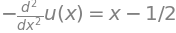

In [212]:
# Statement of the problem

ode = Eq((-u(x).diff(x, x)),(x-Rational(1,2)), domain=Interval(0,1)); ode

In [213]:
# Explicit the RHS inside another expression

rhs = ode.args[1]; rhs

In [214]:
# True solution is given by the example itself

u_true = -x**3/Integer(6)+x**2/Integer(4)-S.One/Integer(12); u_true

## Numerical computation

### K matrix

In [215]:
# The first (and only) element of the e0 component
# From now on, the elements of the basis are called eX, with X their index,
# eXY are the entries of the matrix built with the vectors eX,
# deXY are the elements of the matrix of the derivatives,
# eXeY are the elements of the matrix that has the scalar products as components

# e00 = sy_basis.args[1][0]; e00 # this assignment leads to incompatibility
                                    # with other expressions and simplification
e00 = -x/h + i + S.One; print("e00 =", e00)

e00 = i + 1 - x/h


In [216]:
# enn = sy_basis.args[0][0]; enn
enn = x/h - i + S.One; print("enn =", enn)

enn = -i + 1 + x/h


In [217]:
sy_basis = Piecewise(
    (enn, (x>(i-1)*h)&(x<i*h)),
    (e00, (x>i*h)&(x<(i+1)*h)),
    (0, True),
); sy_basis

⎧         x                             
⎪-i + 1 + ─  for x > h⋅(i - 1) ∧ x < h⋅i
⎪         h                             
⎪                                       
⎨        x                              
⎪i + 1 - ─   for x > h⋅i ∧ x < h⋅(i + 1)
⎪        h                              
⎪                                       
⎩    0                otherwise         

In [218]:
# We build the matrix of the elements starting from a list of lists:
# each sublist is filled with conditional statements with the
# sympy objects e00 and enn that represent the values of the pp basis'
# elements in a given interval (represented by index j). The index i
# loops on the pp basis (from 0 to n) and is substituted in the expr
# e00 and enn. What we obtain is a pure sympy.Matrix object.

elist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a!=0)&(b==a-1): lista[b]=enn.subs(i, a)
        elif a==b: lista[b]=e00.subs(i, a)
        else: lista[b]=0
    elist.append(lista)
e = Matrix(elist); e

⎡    x                                                                        
⎢1 - ─    0       0       0       0       0       0       0       0       0   
⎢    h                                                                        
⎢                                                                             
⎢  x        x                                                                 
⎢  ─    2 - ─     0       0       0       0       0       0       0       0   
⎢  h        h                                                                 
⎢                                                                             
⎢            x      x                                                         
⎢  0    -1 + ─  3 - ─     0       0       0       0       0       0       0   
⎢            h      h                                                         
⎢                                                                             
⎢                    x      x                       

In [219]:
# Build the matrix of the derivatives via a lambda function passed as argument
# to the native sympy method sympy.applyfunc()
# The function differentiates each entry with respect to x.

de = e.applyfunc(lambda entry : entry.diff(x)); de

⎡-1                                              ⎤
⎢───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h                                              ⎥
⎢                                                ⎥
⎢ 1   -1                                         ⎥
⎢ ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                         ⎥
⎢                                                ⎥
⎢      1   -1                                    ⎥
⎢ 0    ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h                                    ⎥
⎢                                                ⎥
⎢           1   -1                               ⎥
⎢ 0    0    ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h                               ⎥
⎢                                                ⎥
⎢                1   -1                          ⎥
⎢ 0    0    0    ─   ───   0    0    0    0    0 ⎥
⎢                h    h                          ⎥
⎢                              

In [220]:
# Implement an interval-wise scalar product by computing the matrix
# product of the matrix of the derivatives and its transpose.
# The resulting matrix is the matrix of the integrands of the matrix Kij,
# and we should call it Iij.

Iij = de*de.T; Iij

⎡1    -1                                              ⎤
⎢──   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ 2     2                                             ⎥
⎢h     h                                              ⎥
⎢                                                     ⎥
⎢-1   2    -1                                         ⎥
⎢───  ──   ───   0    0    0    0    0    0    0    0 ⎥
⎢  2   2     2                                        ⎥
⎢ h   h     h                                         ⎥
⎢                                                     ⎥
⎢     -1   2    -1                                    ⎥
⎢ 0   ───  ──   ───   0    0    0    0    0    0    0 ⎥
⎢       2   2     2                                   ⎥
⎢      h   h     h                                    ⎥
⎢                                                     ⎥
⎢          -1   2    -1                               ⎥
⎢ 0    0   ───  ──   ───   0    0    0    0    0    0 ⎥
⎢            2   2     2                        

In [221]:
# Since the entries of the matrix of the integrands are interval-wise,
# the integrals on each interval, which will be the entries of the matrix
# Kij, can be computed by integrating from 0 to h each entry of Iij.
# This is true only because the entries of Iij don't depend on the index
# of the piecewise element they refer to.

Kij = Iij.applyfunc(lambda entry : entry.integrate((x, S.Zero, h))); Kij

⎡ 1   -1                                              ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                              ⎥
⎢                                                     ⎥
⎢-1    2   -1                                         ⎥
⎢───   ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                         ⎥
⎢                                                     ⎥
⎢     -1    2   -1                                    ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h    h                                    ⎥
⎢                                                     ⎥
⎢          -1    2   -1                               ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h    h                               ⎥
⎢                                                     ⎥
⎢               -1    2   -1                          ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0

### RHS vector

In [222]:
# The rhs function has be defined as a sympy expression

rhs

In [223]:
If = e.applyfunc(lambda entry : entry*rhs); If

⎡⎛    x⎞                                                                      
⎢⎜1 - ─⎟⋅(x - 1/2)          0                   0                   0         
⎢⎝    h⎠                                                                      
⎢                                                                             
⎢   x⋅(x - 1/2)     ⎛    x⎞                                                   
⎢   ───────────     ⎜2 - ─⎟⋅(x - 1/2)           0                   0         
⎢        h          ⎝    h⎠                                                   
⎢                                                                             
⎢                   ⎛     x⎞            ⎛    x⎞                               
⎢        0          ⎜-1 + ─⎟⋅(x - 1/2)  ⎜3 - ─⎟⋅(x - 1/2)           0         
⎢                   ⎝     h⎠            ⎝    h⎠                               
⎢                                                                             
⎢                                       ⎛     x⎞    

In [224]:
# 2. build the matrix with the result of the integration of each
# integrand function (per interval, per piecewise element)

fflist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a==0): lista[b]=expand(If.row(a)[b].integrate((x, S.Zero, h)))
        elif (a==n): lista[b]=expand(If.row(a)[b].integrate((x, S.One-h, S.One)))
        else: lista[b]=expand(If.row(a)[b].integrate((x, b*h, (b+1)*h)))
    fflist.append(lista)
fij = Matrix(fflist); fij

⎡ 2                                                                           
⎢h    h                                                                       
⎢── - ─     0         0          0          0          0          0          0
⎢6    4                                                                       
⎢                                                                             
⎢ 2         2                                                                 
⎢h    h  2⋅h    h                                                             
⎢── - ─  ──── - ─     0          0          0          0          0          0
⎢3    4   3     4                                                             
⎢                                                                             
⎢           2         2                                                       
⎢        5⋅h    h  7⋅h    h                                                   
⎢  0     ──── - ─  ──── - ─      0          0       

In [163]:
# 3. build the vector fi, whose entries are the sums of the integrals
# on each piecewise element. To do that, we project each row on a
# column vector of ones.

ones = Matrix([S.One for i in range(n)])

flist = []
for a in range(n+1):
    flist.append(fij.row(a)*ones)
fi = Matrix(flist); fi

⎡      2         ⎤
⎢     h    h     ⎥
⎢     ── - ─     ⎥
⎢     6    4     ⎥
⎢                ⎥
⎢      2   h     ⎥
⎢     h  - ─     ⎥
⎢          2     ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    2⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    3⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    4⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    5⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    6⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    7⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    8⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    9⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢    2           ⎥
⎢29⋅h    21⋅h   1⎥
⎢───── - ──── + ─⎥
⎣  6      4     2⎦

**Note: the last entry is actually correct, if we consider (and this is done correctly in the computation of the solution), that $nh=1$ and in this particular case $10h=1$.**

### Solution

Being Kij singular, one way to make it full-rank, thus invertible, is to remove its last row and column. The same must be applied to the fi vector, whose last element is popped. In this way, the linear algebra problem **Ku=f** has a unique solution.

In [164]:
Kij

⎡ 1   -1                                              ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                              ⎥
⎢                                                     ⎥
⎢-1    2   -1                                         ⎥
⎢───   ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                         ⎥
⎢                                                     ⎥
⎢     -1    2   -1                                    ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h    h                                    ⎥
⎢                                                     ⎥
⎢          -1    2   -1                               ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h    h                               ⎥
⎢                                                     ⎥
⎢               -1    2   -1                          ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0

In [165]:
K = Kij[0:-1, 0:-1]; K

⎡ 1   -1                                         ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                         ⎥
⎢                                                ⎥
⎢-1    2   -1                                    ⎥
⎢───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                    ⎥
⎢                                                ⎥
⎢     -1    2   -1                               ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢      h    h    h                               ⎥
⎢                                                ⎥
⎢          -1    2   -1                          ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0 ⎥
⎢           h    h    h                          ⎥
⎢                                                ⎥
⎢               -1    2   -1                     ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0 ⎥
⎢                h    h    h                     ⎥
⎢                              

In [166]:
shape(K)

In [167]:
f = Matrix(fi[:-1]); f

⎡  2     ⎤
⎢ h    h ⎥
⎢ ── - ─ ⎥
⎢ 6    4 ⎥
⎢        ⎥
⎢  2   h ⎥
⎢ h  - ─ ⎥
⎢      2 ⎥
⎢        ⎥
⎢   2   h⎥
⎢2⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢3⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢4⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢5⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢6⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢7⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢8⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢9⋅h  - ─⎥
⎣       2⎦

In [168]:
shape(f)

In [169]:
ui = K.LUsolve(f); ui = ui.applyfunc(lambda x : expand(x)); ui

⎡     3        ⎤
⎢500⋅h        2⎥
⎢────── - 25⋅h ⎥
⎢  3           ⎥
⎢              ⎥
⎢     3       2⎥
⎢333⋅h    99⋅h ⎥
⎢────── - ─────⎥
⎢  2        4  ⎥
⎢              ⎥
⎢     3        ⎥
⎢496⋅h        2⎥
⎢────── - 24⋅h ⎥
⎢  3           ⎥
⎢              ⎥
⎢     3       2⎥
⎢973⋅h    91⋅h ⎥
⎢────── - ─────⎥
⎢  6        4  ⎥
⎢              ⎥
⎢     3       2⎥
⎢156⋅h  - 21⋅h ⎥
⎢              ⎥
⎢     3       2⎥
⎢875⋅h    75⋅h ⎥
⎢────── - ─────⎥
⎢  6        4  ⎥
⎢              ⎥
⎢     3        ⎥
⎢392⋅h        2⎥
⎢────── - 16⋅h ⎥
⎢  3           ⎥
⎢              ⎥
⎢     3       2⎥
⎢219⋅h    51⋅h ⎥
⎢────── - ─────⎥
⎢  2        4  ⎥
⎢              ⎥
⎢     3        ⎥
⎢244⋅h       2 ⎥
⎢────── - 9⋅h  ⎥
⎢  3           ⎥
⎢              ⎥
⎢     3       2⎥
⎢271⋅h    19⋅h ⎥
⎢────── - ─────⎥
⎣  6        4  ⎦

In [170]:
shape(ui)

In [171]:
# First thing to do is to provide a basis of piecewise polynomials that
# has proper dimensions wrt to the solution that we have obtained.
# Deleting the last row and column from K and f has provided us with
# a n-dimensional solution, not (n+1).
# So we have to drop the last row of e, relative to piecewise element n.
# Notice that in this way we only lose a piece of information on the last
# interval, and this is clearly seen in the error plot, which doesn't
# vanishes on the last node

redu_e = e[0:-1, :]; redu_e

⎡    x                                                                        
⎢1 - ─    0       0       0       0       0       0       0       0       0   
⎢    h                                                                        
⎢                                                                             
⎢  x        x                                                                 
⎢  ─    2 - ─     0       0       0       0       0       0       0       0   
⎢  h        h                                                                 
⎢                                                                             
⎢            x      x                                                         
⎢  0    -1 + ─  3 - ─     0       0       0       0       0       0       0   
⎢            h      h                                                         
⎢                                                                             
⎢                    x      x                       

In [172]:
u = (ui.T*redu_e).subs(h, hvalue).evalf(5);
u = u.subs(h, hvalue).evalf(5); Matrix(u).T

⎡0.023333⋅x - 0.083333⎤
⎢                     ⎥
⎢0.063333⋅x - 0.087333⎥
⎢                     ⎥
⎢0.093333⋅x - 0.093333⎥
⎢                     ⎥
⎢0.11333⋅x - 0.099333 ⎥
⎢                     ⎥
⎢ 0.12333⋅x - 0.10333 ⎥
⎢                     ⎥
⎢ 0.12333⋅x - 0.10333 ⎥
⎢                     ⎥
⎢0.11333⋅x - 0.097333 ⎥
⎢                     ⎥
⎢0.093333⋅x - 0.083333⎥
⎢                     ⎥
⎢0.063333⋅x - 0.059333⎥
⎢                     ⎥
⎣0.023333⋅x - 0.023333⎦

## Plots

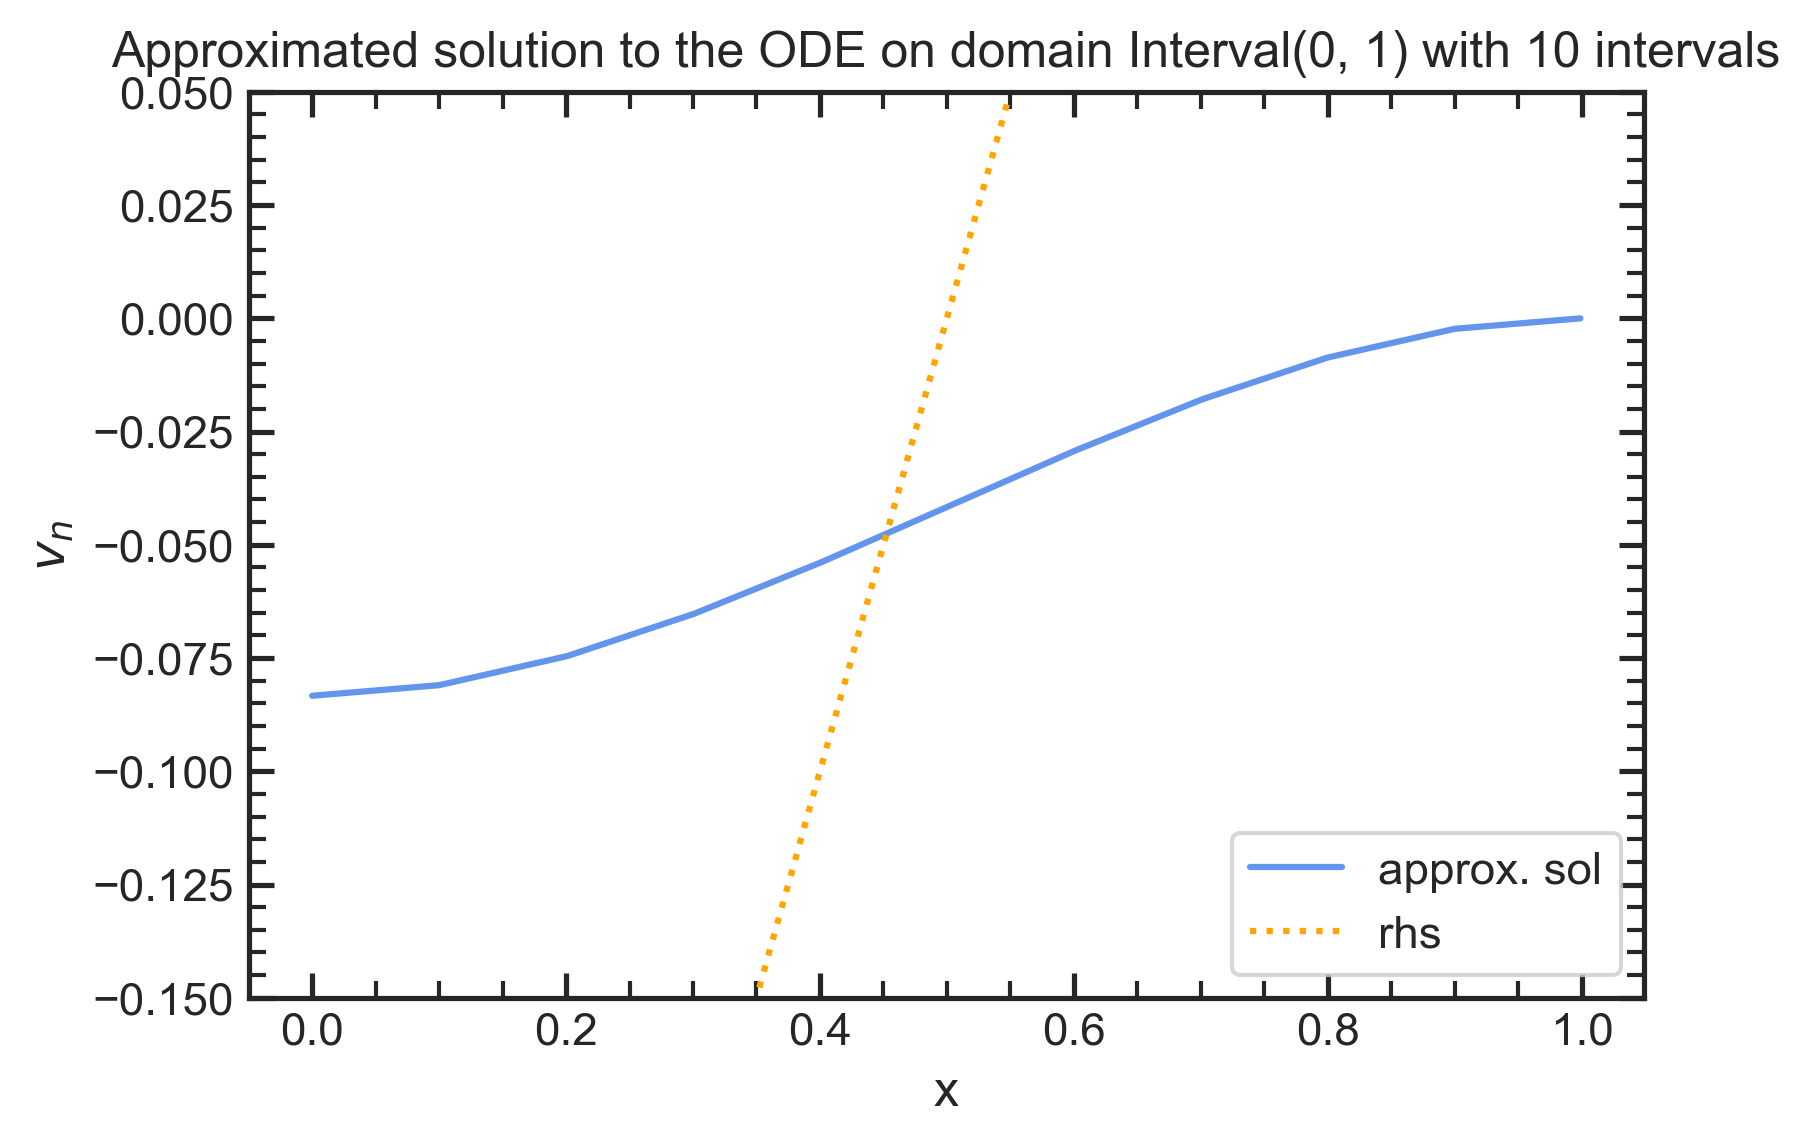

In [173]:
# We evaluate the values of the solution on a grid of 10 subintervals
# per interval (as done before in refined), with a step of 1/hvalue

yrefined = []
xrefined = []
for index, entry in enumerate(list(u)):
    for subinterval in range(npoints_per_interval):
        xval = hvalue*index+x_subvalue*subinterval
        yrefined.append(entry.subs(x, xval).evalf(5))
        xrefined.append(round(xval, 5))
yrefined = np.array(yrefined)
xrefined = np.array(xrefined)

y_truerefined = np.array([u_true.subs(x, xrefined[i]).evalf(5) for i in range(len(xrefined))]); # y_truerefined
f_refined = np.array([rhs.subs(x, xrefined[i]).evalf(5) for i in range(len(xrefined))]); # f_refined
error_refined = y_truerefined-yrefined; # error_refined

plt.close()

# Plot of the approximated solution
plt.figure(2, figsize=(6,4), dpi=300)
plt.plot(xrefined, yrefined, color='cornflowerblue', label='approx. sol')
plt.plot(xrefined, f_refined, color='orange', linestyle=':', label='rhs')
plt.xlabel('x')
plt.ylabel(r'$v_n$')
plt.title(f'Approximated solution to the ODE on domain {domain.closure} with {n} intervals')
plt.legend(loc='lower right')
plt.ylim(-.15, .05)
plt.show()

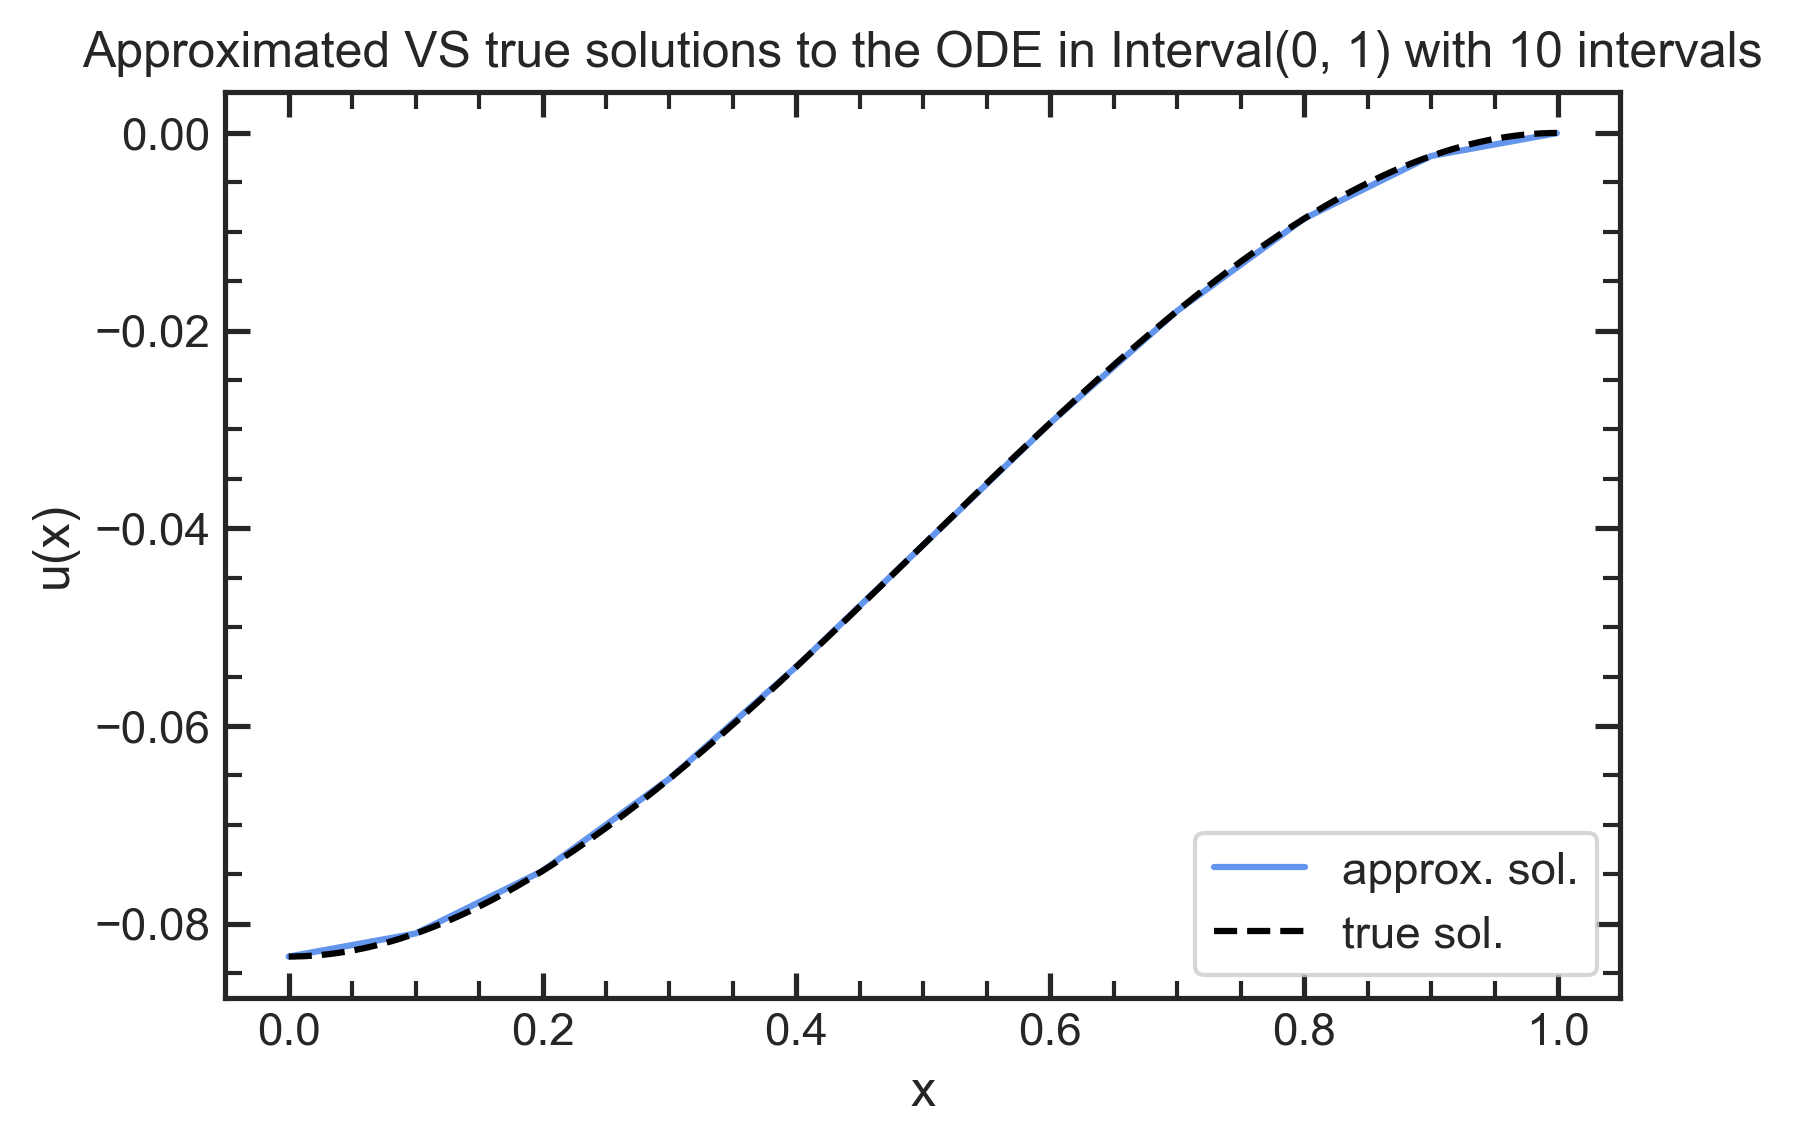

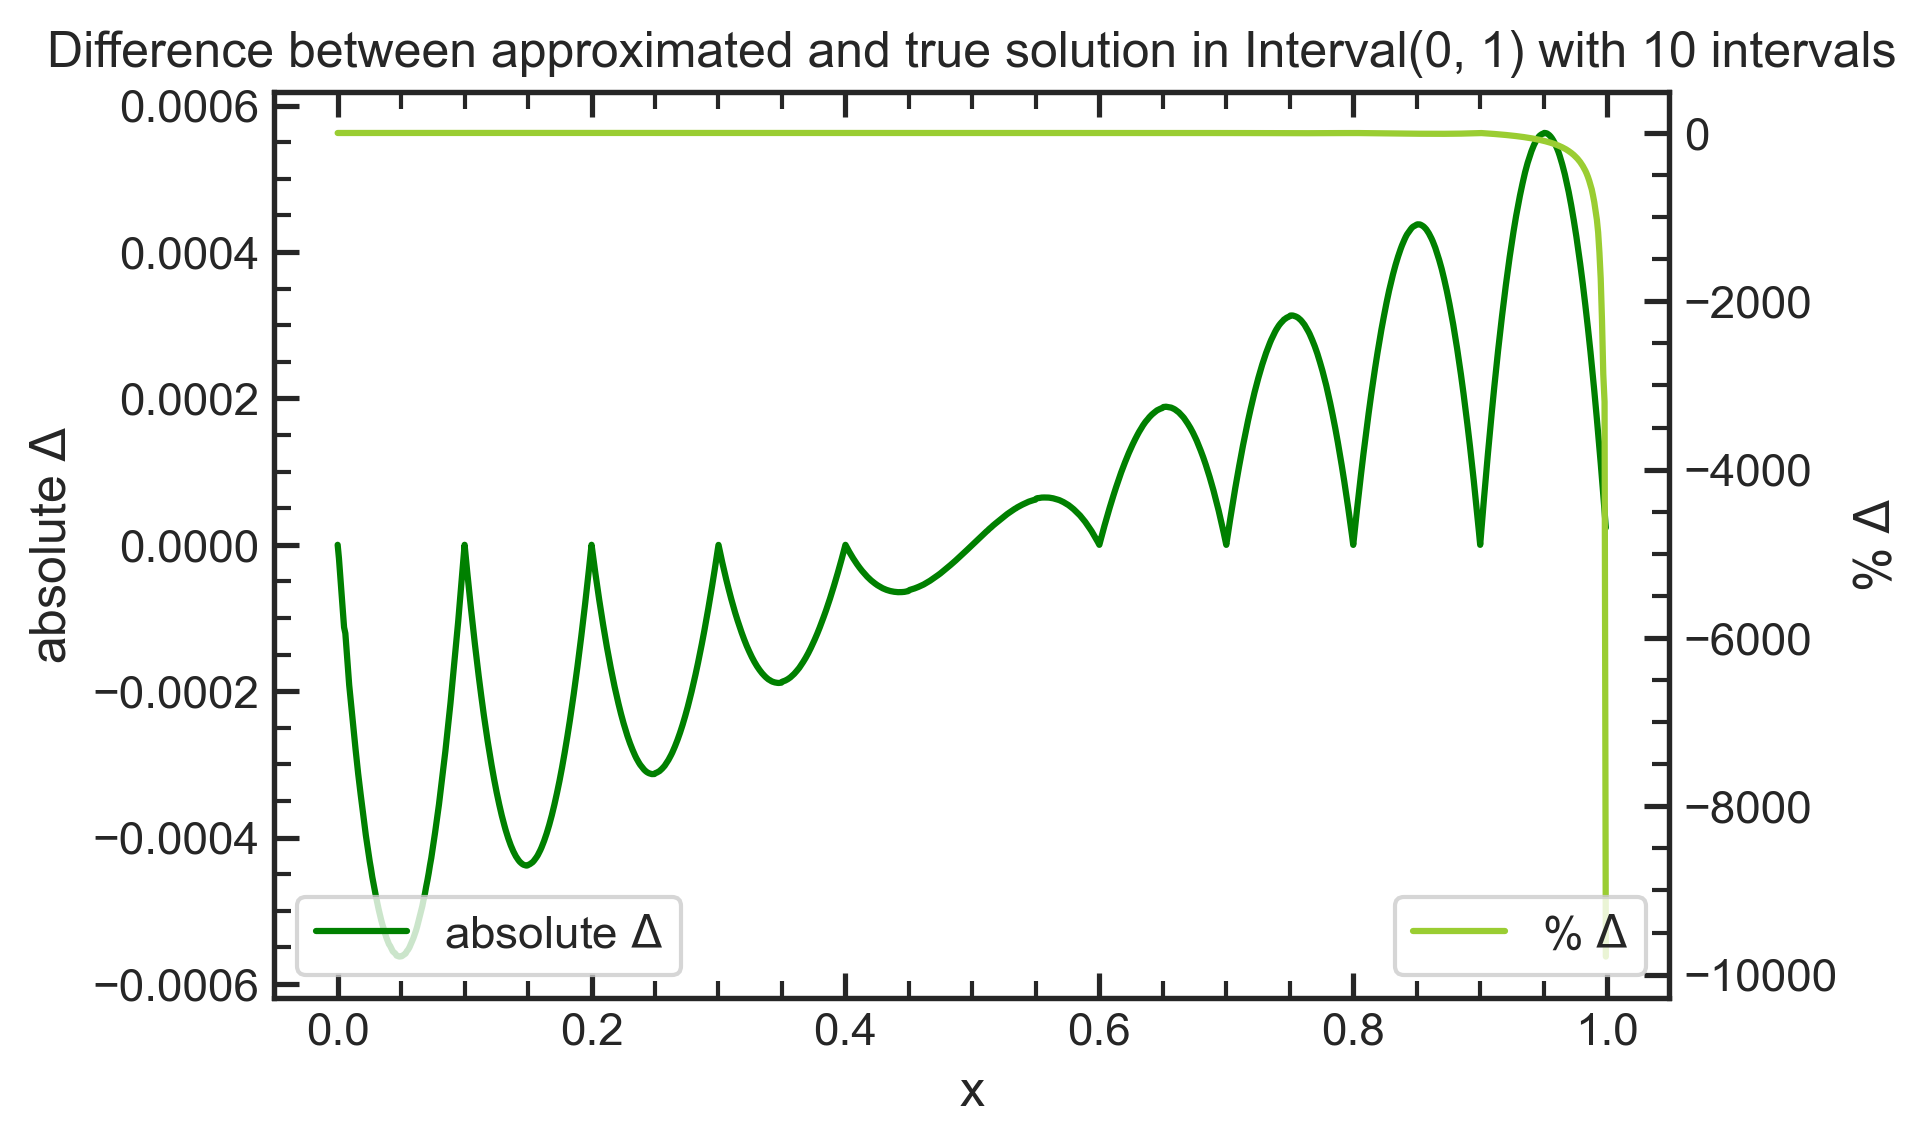

In [174]:
# Plot of the true solution VS approximated and of the difference between
# WARNING: run only if you have provided a true solution

plt.figure(2, figsize=(6,4), dpi=300)
plt.plot(xrefined, yrefined, color='cornflowerblue', label='approx. sol.')
plt.plot(xrefined, y_truerefined, linestyle='--', color='black', label='true sol.')
plt.title(f'Approximated VS true solutions to the ODE in {domain.closure} with {n} intervals')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend(loc='lower right')

fig, ax = plt.subplots(figsize=(6,4), dpi=300)
diff, = ax.plot(xrefined, error_refined, color='green', label=r'absolute $\Delta$')
ax.set_title(f'Difference between approximated and true solution in {domain.closure} with {n} intervals')
ax.set_xlabel('x')
ax.set_ylabel(r'absolute $\Delta$')
ax.legend(loc='lower left')

ax1 = ax.twinx()

diffPerc, = ax1.plot(xrefined, error_refined/y_truerefined*100, color='yellowgreen', label=r'% $\Delta$')
ax1.set_xlabel('x')
ax1.set_ylabel(r'% $\Delta$')
ax1.legend(loc='lower right')

plt.show()

---

# Example 6.10 - Same problem, under homogeneous Dirichlet BC

We now take the same problem that we solved above, but imposing homogeneous Dirichlet boundary conditions. \
**We will skip the computation of the K matrix, since we have already computed it. The RHS vector's computation is performed again to allow for any eventual manipulation of the RHS in an easy way.**


Reference: M. S. Gockenbach, _Partial Differential Equations - Analytical and Numerical Methods_, 2nd edition, Siam. Section 6.5 - Finite elements and Neumann conditions.

## Statement of the problem

In [175]:
    # ----------------------------------------------------------------------
        # Parameters to fix

# Solution's domain
domain = Interval(0,1)

# Number of intervals in which to divide the domain
n = 10

# Width of each interval
hvalue = (domain.measure/n).evalf()

    # ----------------------------------------------------------------------
        # Main variables definition

u = symbols('u', cls=Function)
x = Symbol('x', real=True, domain=domain)
h = Symbol('h', real=True, positive=True)
i = Symbol('i', integer=True)

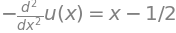

In [176]:
ode = Eq((-u(x).diff(x, x)),(x-Rational(1,2)), domain=Interval(0,1)); ode

In [177]:
# Explicit the RHS inside another expression

rhs = ode.args[1]; rhs

In [178]:
# Impose boundary conditions to compute automatically the true solution
ics = {
    u(0) : 0,
    u(1) : 0,
}

In [179]:
# Solve the ODE with provided boundary conditions

dsolve(ode, func=u(x), ics=ics)

In [180]:
u_true = (dsolve(ode, func=u(x), ics=ics)).args[1]; u_true

## Numerical computation

### RHS vector

In [181]:
If = e.applyfunc(lambda entry : entry*rhs); If

⎡⎛    x⎞                                                                      
⎢⎜1 - ─⎟⋅(x - 1/2)          0                   0                   0         
⎢⎝    h⎠                                                                      
⎢                                                                             
⎢   x⋅(x - 1/2)     ⎛    x⎞                                                   
⎢   ───────────     ⎜2 - ─⎟⋅(x - 1/2)           0                   0         
⎢        h          ⎝    h⎠                                                   
⎢                                                                             
⎢                   ⎛     x⎞            ⎛    x⎞                               
⎢        0          ⎜-1 + ─⎟⋅(x - 1/2)  ⎜3 - ─⎟⋅(x - 1/2)           0         
⎢                   ⎝     h⎠            ⎝    h⎠                               
⎢                                                                             
⎢                                       ⎛     x⎞    

In [182]:
fflist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a==0): lista[b]=expand(If.row(a)[b].integrate((x, S.Zero, h)))
        elif (a==n): lista[b]=expand(If.row(a)[b].integrate((x, S.One-h, S.One)))
        else: lista[b]=expand(If.row(a)[b].integrate((x, b*h, (b+1)*h)))
    fflist.append(lista)
fij = Matrix(fflist); fij

⎡ 2                                                                           
⎢h    h                                                                       
⎢── - ─     0         0          0          0          0          0          0
⎢6    4                                                                       
⎢                                                                             
⎢ 2         2                                                                 
⎢h    h  2⋅h    h                                                             
⎢── - ─  ──── - ─     0          0          0          0          0          0
⎢3    4   3     4                                                             
⎢                                                                             
⎢           2         2                                                       
⎢        5⋅h    h  7⋅h    h                                                   
⎢  0     ──── - ─  ──── - ─      0          0       

In [183]:
ones = Matrix([S.One for i in range(n)])

flist = []
for a in range(n+1):
    flist.append(fij.row(a)*ones)
fi = Matrix(flist); fi

⎡      2         ⎤
⎢     h    h     ⎥
⎢     ── - ─     ⎥
⎢     6    4     ⎥
⎢                ⎥
⎢      2   h     ⎥
⎢     h  - ─     ⎥
⎢          2     ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    2⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    3⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    4⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    5⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    6⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    7⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    8⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢       2   h    ⎥
⎢    9⋅h  - ─    ⎥
⎢           2    ⎥
⎢                ⎥
⎢    2           ⎥
⎢29⋅h    21⋅h   1⎥
⎢───── - ──── + ─⎥
⎣  6      4     2⎦

### Solution

Both the first and last row and column are to be taken away from the matrix K, and the first and last element from the f vector, to provide the correct solution for this kind of boundary conditions.  

In [184]:
K = Kij[1:-1, 1:-1]; K

⎡ 2   -1                                    ⎤
⎢ ─   ───   0    0    0    0    0    0    0 ⎥
⎢ h    h                                    ⎥
⎢                                           ⎥
⎢-1    2   -1                               ⎥
⎢───   ─   ───   0    0    0    0    0    0 ⎥
⎢ h    h    h                               ⎥
⎢                                           ⎥
⎢     -1    2   -1                          ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0 ⎥
⎢      h    h    h                          ⎥
⎢                                           ⎥
⎢          -1    2   -1                     ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0 ⎥
⎢           h    h    h                     ⎥
⎢                                           ⎥
⎢               -1    2   -1                ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0 ⎥
⎢                h    h    h                ⎥
⎢                                           ⎥
⎢                    -1    2   -1           ⎥
⎢ 0    0    0    0   ───   ─   ───

In [185]:
shape(K)

In [186]:
f = Matrix(fi[1:-1]); f

⎡  2   h ⎤
⎢ h  - ─ ⎥
⎢      2 ⎥
⎢        ⎥
⎢   2   h⎥
⎢2⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢3⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢4⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢5⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢6⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢7⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢8⋅h  - ─⎥
⎢       2⎥
⎢        ⎥
⎢   2   h⎥
⎢9⋅h  - ─⎥
⎣       2⎦

In [187]:
shape(f)

In [188]:
ui = K.LUsolve(f); ui = ui.applyfunc(lambda x : expand(x)); ui

⎡     3      2 ⎤
⎢ 33⋅h    9⋅h  ⎥
⎢ ───── - ──── ⎥
⎢   2      4   ⎥
⎢              ⎥
⎢     3      2 ⎥
⎢ 32⋅h  - 4⋅h  ⎥
⎢              ⎥
⎢    3       2 ⎥
⎢91⋅h    21⋅h  ⎥
⎢───── - ───── ⎥
⎢  2       4   ⎥
⎢              ⎥
⎢     3      2 ⎥
⎢ 56⋅h  - 6⋅h  ⎥
⎢              ⎥
⎢     3       2⎥
⎢125⋅h    25⋅h ⎥
⎢────── - ─────⎥
⎢  2        4  ⎥
⎢              ⎥
⎢     3      2 ⎥
⎢ 64⋅h  - 6⋅h  ⎥
⎢              ⎥
⎢     3       2⎥
⎢119⋅h    21⋅h ⎥
⎢────── - ─────⎥
⎢  2        4  ⎥
⎢              ⎥
⎢     3      2 ⎥
⎢ 48⋅h  - 4⋅h  ⎥
⎢              ⎥
⎢     3      2 ⎥
⎢ 57⋅h    9⋅h  ⎥
⎢ ───── - ──── ⎥
⎣   2      4   ⎦

In [189]:
shape(ui)

In [190]:
redu_e = e[1:-1, :]; redu_e

⎡x      x                                                                 ⎤
⎢─  2 - ─     0       0       0       0       0       0       0       0   ⎥
⎢h      h                                                                 ⎥
⎢                                                                         ⎥
⎢        x      x                                                         ⎥
⎢0  -1 + ─  3 - ─     0       0       0       0       0       0       0   ⎥
⎢        h      h                                                         ⎥
⎢                                                                         ⎥
⎢                x      x                                                 ⎥
⎢0    0     -2 + ─  4 - ─     0       0       0       0       0       0   ⎥
⎢                h      h                                                 ⎥
⎢                                                                         ⎥
⎢                        x      x                                         ⎥
⎢0    0     

In [191]:
u = (ui.T*redu_e).subs(h, hvalue).evalf(5);
u = u.subs(h, hvalue).evalf(5); u.T

⎡      -0.06⋅x      ⎤
⎢                   ⎥
⎢  -0.02⋅x - 0.004  ⎥
⎢                   ⎥
⎢   0.01⋅x - 0.01   ⎥
⎢                   ⎥
⎢  0.03⋅x - 0.016   ⎥
⎢                   ⎥
⎢   0.04⋅x - 0.02   ⎥
⎢                   ⎥
⎢   0.04⋅x - 0.02   ⎥
⎢                   ⎥
⎢  0.03⋅x - 0.014   ⎥
⎢                   ⎥
⎢0.01⋅x - 5.5511e-17⎥
⎢                   ⎥
⎢  0.024 - 0.02⋅x   ⎥
⎢                   ⎥
⎣   0.06 - 0.06⋅x   ⎦

## Plots

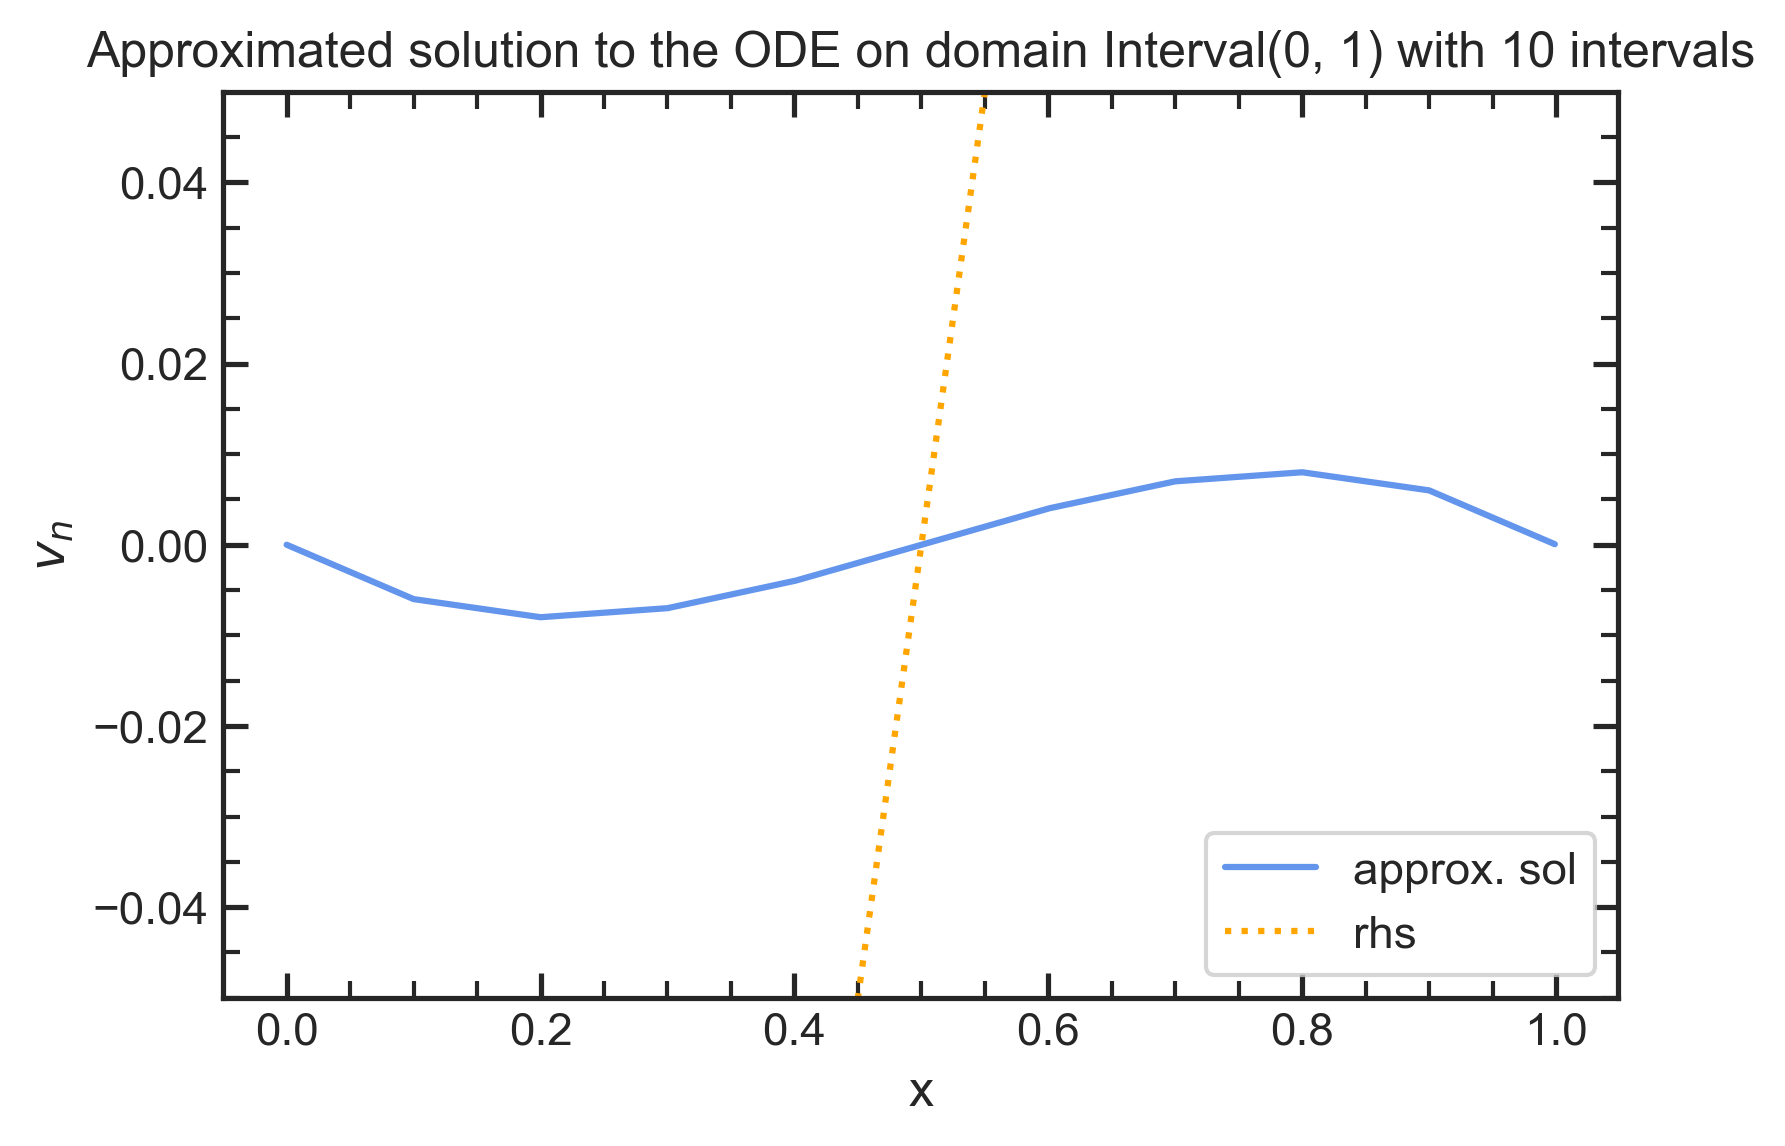

In [192]:
# We evaluate the values of the solution on a grid of 10 subintervals
# per interval (as done before in refined), with a step of 1/hvalue

yrefined = []
xrefined = []
for index, entry in enumerate(list(u)):
    for subinterval in range(npoints_per_interval):
        xval = hvalue*index+x_subvalue*subinterval
        yrefined.append(entry.subs(x, xval).evalf(5))
        xrefined.append(round(xval, 5))
yrefined = np.array(yrefined)
xrefined = np.array(xrefined)

y_truerefined = np.array([u_true.subs(x, xrefined[i]).evalf(5) for i in range(len(xrefined))]); # y_truerefined
f_refined = np.array([rhs.subs(x, xrefined[i]).evalf(5) for i in range(len(xrefined))]); # f_refined
error_refined = y_truerefined-yrefined; # error_refined

plt.close()

# Plot of the approximated solution
plt.figure(2, figsize=(6,4), dpi=300)
plt.plot(xrefined, yrefined, color='cornflowerblue', label='approx. sol')
plt.plot(xrefined, f_refined, color='orange', linestyle=':', label='rhs')
plt.xlabel('x')
plt.ylabel(r'$v_n$')
plt.title(f'Approximated solution to the ODE on domain {domain.closure} with {n} intervals')
plt.legend(loc='lower right')
plt.ylim(-.05, .05)
plt.show()

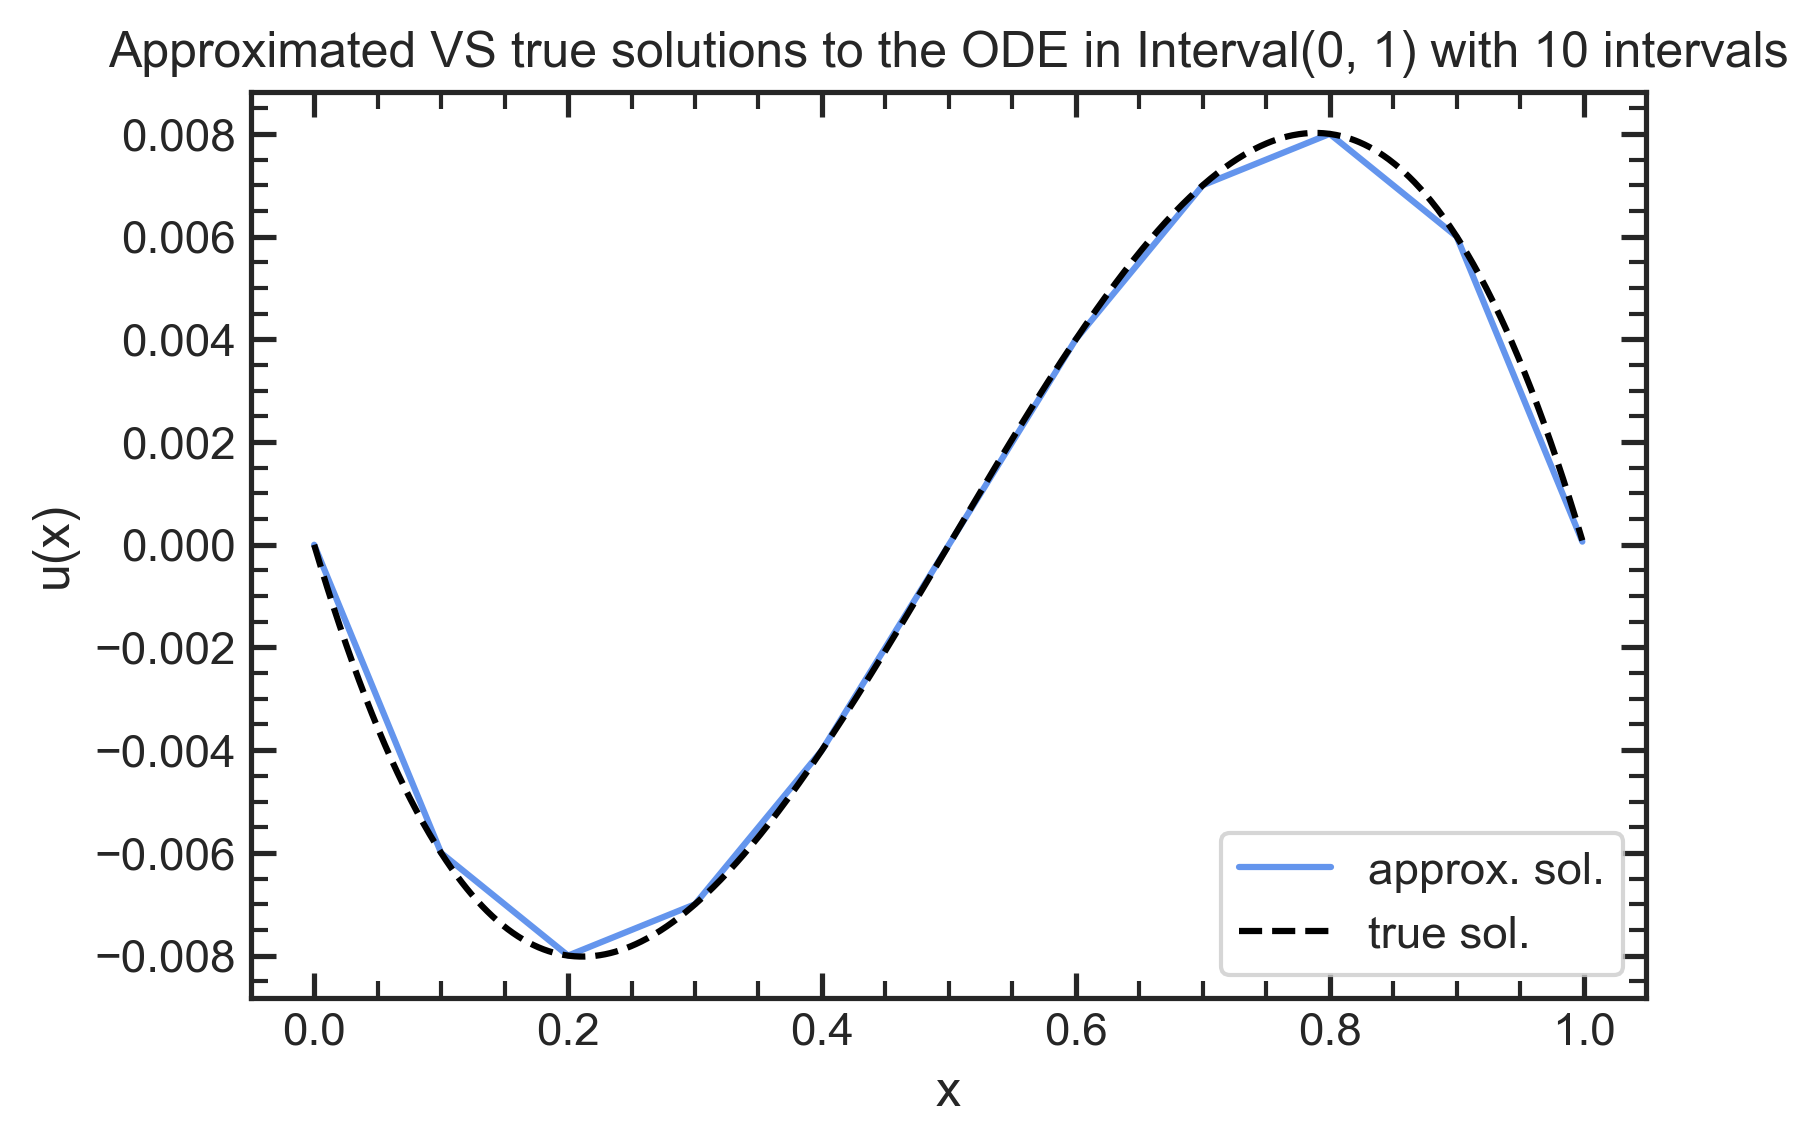

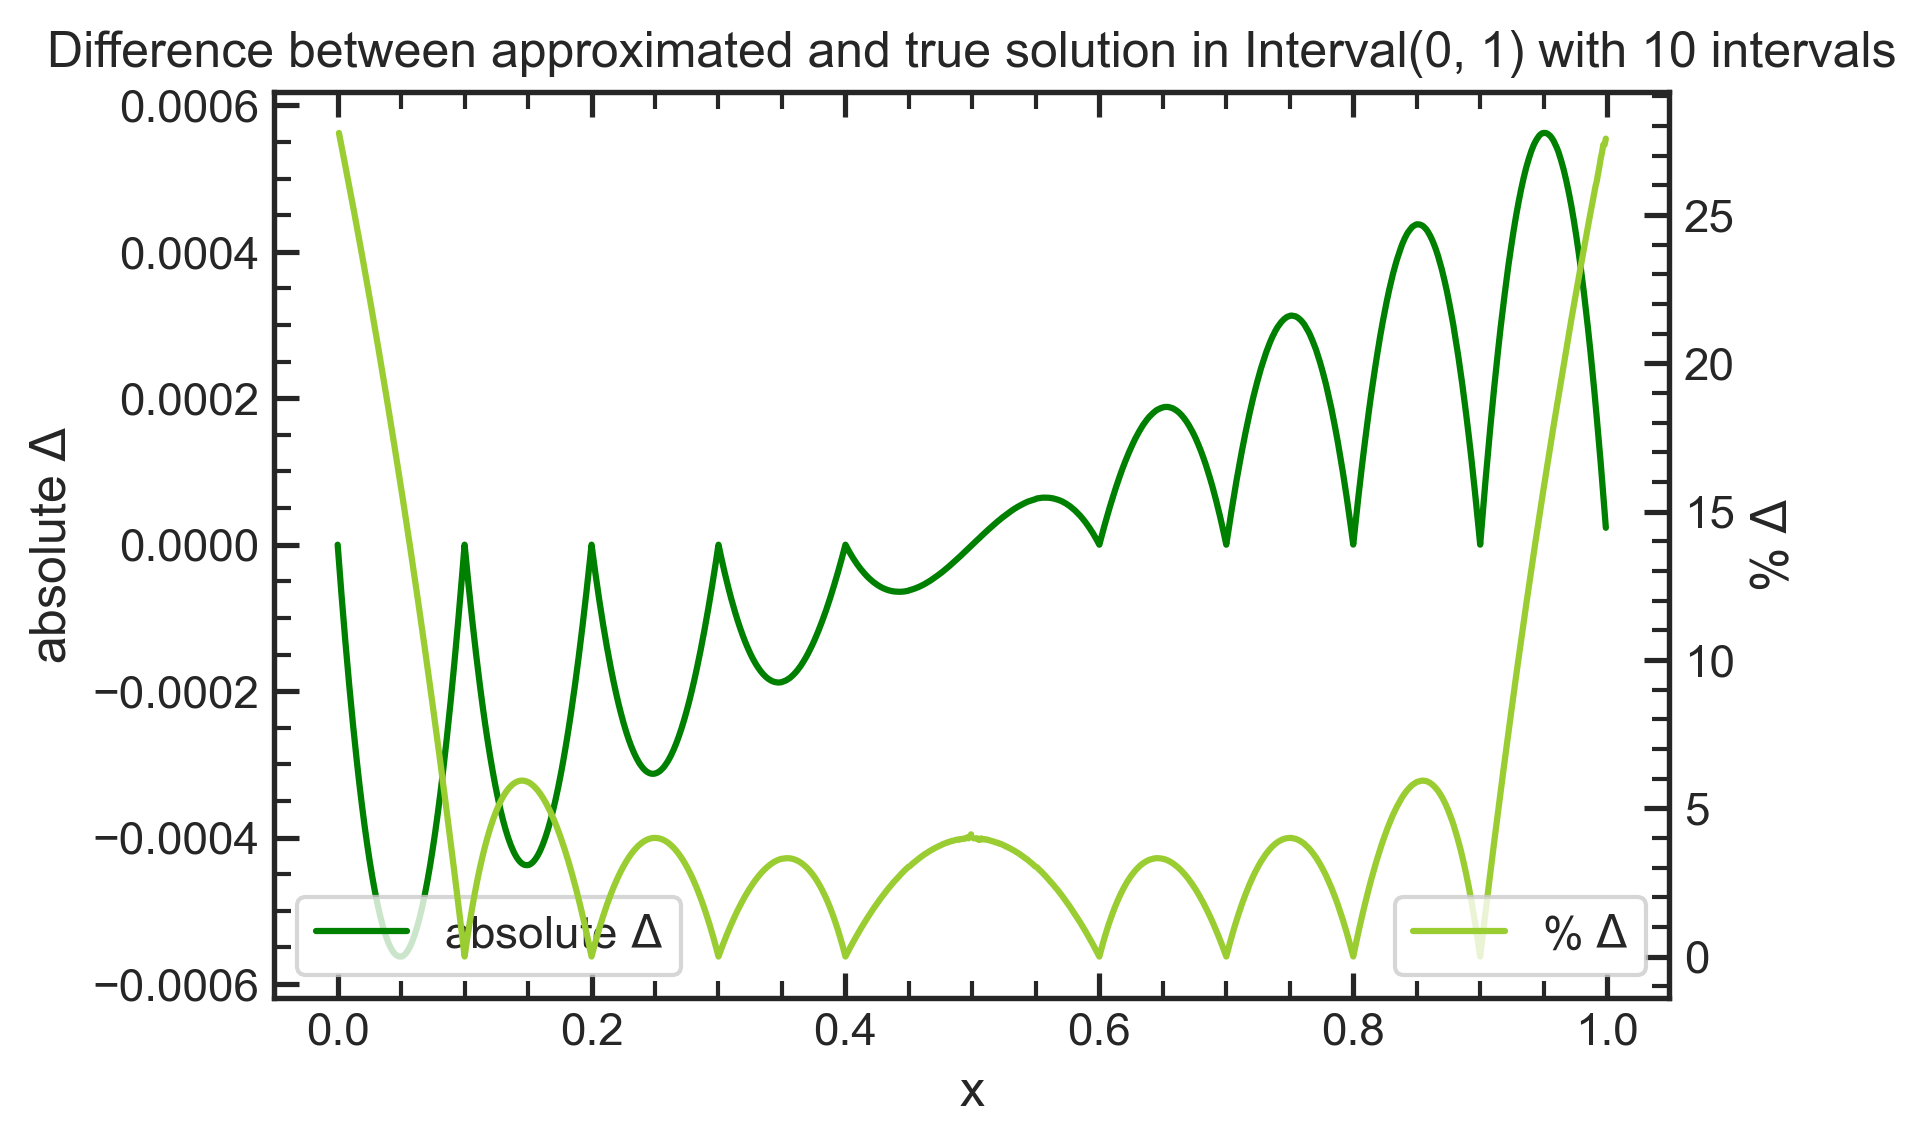

In [193]:
# Plot of the true solution VS approximated and of the difference between
# WARNING: run only if you have provided a true solution

plt.figure(2, figsize=(6,4), dpi=300)
plt.plot(xrefined, yrefined, color='cornflowerblue', label='approx. sol.')
plt.plot(xrefined, y_truerefined, linestyle='--', color='black', label='true sol.')
plt.title(f'Approximated VS true solutions to the ODE in {domain.closure} with {n} intervals')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend(loc='lower right')

fig, ax = plt.subplots(figsize=(6,4), dpi=300)
diff, = ax.plot(xrefined, error_refined, color='green', label=r'absolute $\Delta$', zorder=3)
ax.set_title(f'Difference between approximated and true solution in {domain.closure} with {n} intervals')
ax.set_xlabel('x')
ax.set_ylabel(r'absolute $\Delta$')
ax.legend(loc='lower left')

ax1 = ax.twinx()

diffPerc, = ax1.plot(xrefined, error_refined/y_truerefined*100, color='yellowgreen', label=r'% $\Delta$', zorder=-2)
ax1.set_xlabel('x')
ax1.set_ylabel(r'% $\Delta$')
ax1.legend(loc='lower right')

plt.show()